# Ridge and Lasso Regression

The dataset consists of ten features and one target variable.  More information is found at http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset

After importing the datasets, add additional interaction variables to the features matrix.  You should have 55 variables (including 45 interaction variables) and one target variable. Add one term for every pair of variables; in practice one may introduce only a few select interaction terms based on domain knowledge or experimentation.

In this question, you will explore the application of Lasso and Ridge regression using sklearn package in Python. The following code will split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 20** and **test_size = 0.33**.  Note: lambda is called alpha in sklearn.

1) Use sklearn.linear_model.Lasso and sklearn.linear_model.Ridge classes to do a [5-fold cross validation](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html). For the sweep of the regularization parameter, we will look at a grid of values ranging from $\lambda = 10^{10}$ to $\lambda = 10^{-2}$. In Python, you can consider this range of values as follows:

      import numpy as np

      alphas =  10**np.linspace(10,-2,100)*0.5

  Report the best chosen $\lambda$ based on cross validation. The cross validation should happen on your training data using  average MSE as the scoring metric. (5pts)

2) Run ridge and lasso for all of the alphas specified above (on training data), and plot the coefficients learned for each of them - there should be one plot each for lasso and ridge, so a total of two plots; the plots for different features for a method should be on the same plot (e.g. Fig 6.6 of JW). What do you qualitatively observe when value of the regularization parameter is changed? (4pts)

3) Run least squares regression, ridge, and lasso on the training data. For ridge and lasso, use only the best regularization parameter. Report the prediction error (MSE) on the test data for each. (3pts)

4) Run lasso again with cross validation using [sklearn.linear_model.LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Set the cross validation parameters as follows:

    LassoCV(alphas=None, cv=10, max_iter=10000)

Report the best $\lambda$ based on cross validation. Run lasso on the training data using the best $\lambda$ and report the coefficeints for 55 variables. What do you observe from these coefficients? (3pts)

## Solution

### 1)

In [1]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

In [2]:
from sklearn.preprocessing import PolynomialFeatures
X = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(X)

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=20)

/Users/kyungwoo/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import pandas as pd
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

n_folds = 5
k_fold = cross_validation.KFold(len(X_train), n_folds)
lasso_alphas =  10**np.linspace(10,-2,100)*0.5
lasso_avg_rmse = {}

for alpha in lasso_alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    avg_mse = 0
    for k, (train, test) in enumerate(k_fold):
        lasso.fit(X_train[train], y_train[train])
        avg_mse = avg_mse + mean_squared_error(y_train[test], lasso.predict(X_train[test])) 
    lasso_avg_rmse[alpha] = avg_mse / n_folds
best_alpha_lasso = min(lasso_avg_rmse, key=lasso_avg_rmse.get)
print("Best lasso alpha: {}".format(best_alpha_lasso))


ridge_alphas =  10**np.linspace(10,-2,100)*0.5
ridge_avg_rmse = {}

for alpha in ridge_alphas:
    ridge = linear_model.Ridge(alpha=alpha)
    avg_mse = 0
    for k, (train, test) in enumerate(k_fold):
        ridge.fit(X_train[train], y_train[train])
        avg_mse = avg_mse + mean_squared_error(y_train[test], ridge.predict(X_train[test])) 
    ridge_avg_rmse[alpha] = avg_mse / n_folds
best_alpha_ridge = min(ridge_avg_rmse, key=ridge_avg_rmse.get)
print("Best ridge alpha: {}".format(best_alpha_ridge))

Best lasso alpha: 0.00660970574233
Best ridge alpha: 0.005


### 2)

In [5]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = linear_model.Ridge(alpha=alpha)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [6]:
alphas = 10**np.linspace(10,-2,100)*0.5

lasso = linear_model.Lasso(alpha=alpha)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

Lasso tends to zero out the feature coefficients while Ridge decreases the magnitude of the feature coefficients.

### 3)

In [7]:
#%% (3) - train and test MSE
linear_clf = linear_model.LinearRegression()
ridge_clf = linear_model.Ridge(alpha=best_alpha_ridge)
lasso_clf = linear_model.Lasso(alpha=best_alpha_lasso)

def fit_reg(model, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    print("MSE for {0}: {1}".format(name, mse))

fit_reg(linear_clf, "linear")
fit_reg(ridge_clf, "ridge")
fit_reg(lasso_clf, "lasso")

MSE for linear: 3377.94455926
MSE for ridge: 2959.81880664
MSE for lasso: 2972.25999624


### 4)

In [8]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(X_train, y_train)
print lassocv.alpha_

0.00598825050149


In [9]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print mean_squared_error(y_test, lasso.predict(X_test))

2977.9684786


In [10]:
print pd.Series(lasso.coef_)

0       -8.945181
1     -197.429177
2      565.596546
3      346.757826
4     -946.194163
5      732.361940
6       66.314443
7        0.000000
8      826.206133
9        6.442448
10    2520.577652
11       0.000000
12       0.000000
13       0.000000
14      -0.000000
15       0.000000
16       0.000000
17    1532.331575
18      -0.000000
19       0.000000
20     682.004315
21       0.000000
22       0.000000
23       0.000000
24   -1215.558781
25       0.000000
26       0.000000
27    1076.317504
28       0.000000
29       0.000000
30      -0.000000
31       0.000000
32       0.000000
33    1151.350615
34      80.803344
35       0.000000
36     682.635731
37      -0.000000
38       0.000000
39      -0.000000
40       0.000000
41       0.000000
42      -0.000000
43       0.000000
44       0.000000
45      -0.000000
46      -0.000000
47     585.751561
48       0.000000
49      -0.000000
50       0.000000
51       0.000000
52       0.000000
53     966.133960
54       0.000000
dtype: flo

Some of the coefficients are now reduced to exactly zero.

# Multi-layer Perceptron Regressor

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the Boston house-prices dataset for this problem http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html.


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=40, learning_rate_init = 0.005
    
Now, consider three different settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* (b) *hidden_layer_sizes = (8,)* (c) *hidden_layer_sizes = (15,)*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (a), (b), and (c) (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best, (a), (b), or (c)? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=40, hidden_layer_sizes = (15,)
    
Now, consider three different settings for the learning rates:
    
   (i) *learning_rate_init = 0.005* (ii) *learning_rate_init = 0.01* (iii) *learning_rate_init = 1*
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model: (i), (ii), and (iii) (5pts)



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
data = datasets.load_boston()
feature_cols = data.feature_names
X = pd.DataFrame(data.data, columns = feature_cols)
y = pd.Series(data.target)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)


## Solution

### 1)

In [12]:
param_hidden_layers = [(2,),(8,),(15,)]

n_folds = 5
k_folds = KFold(n_splits=n_folds)
lrate = 0.005

for param_hidden in param_hidden_layers:
    aRMSE = 0
    for train_idx, test_idx in k_folds.split(X_train):
        regMLP = MLPRegressor(activation = 'tanh',
                              solver = 'sgd',
                              learning_rate='constant',
                              random_state=42,
                              batch_size=40,
                              learning_rate_init = lrate,
                              hidden_layer_sizes = param_hidden)
        stdScaler = StandardScaler()
        xTrain = stdScaler.fit_transform(X_train.iloc[train_idx,:])
        yTrain = y_train.iloc[train_idx]
            
        regMLP.fit(xTrain,yTrain)
        aRMSE += np.sqrt(mean_squared_error(y_train.iloc[test_idx],
                                            regMLP.predict(stdScaler.transform(X_train.iloc[test_idx,:]))))/n_folds
    
    print '<hidden layer: {}>\n Average RMSE (CV): {}\n'.format(param_hidden,aRMSE)


<hidden layer: (2,)>
 Average RMSE (CV): 5.65299177605

<hidden layer: (8,)>
 Average RMSE (CV): 4.45561264758

<hidden layer: (15,)>
 Average RMSE (CV): 3.82804387751



### 2)

In [13]:
lrate = 0.005
param_hidden_layers = [(2,),(8,),(15,)]

RMSE_train_test = {}
regMLPs = {}
for param_hidden in param_hidden_layers:
    regMLP = MLPRegressor(activation = 'tanh',
                          solver = 'sgd',
                          learning_rate='constant',
                          random_state=42,
                          batch_size=40,
                          learning_rate_init = lrate,
                          hidden_layer_sizes = param_hidden)
    stdScaler = StandardScaler()
    xTrain = stdScaler.fit_transform(X_train)
    regMLP.fit(xTrain,y_train)
    RMSE_train_test[param_hidden] = [np.sqrt(mean_squared_error(y_train,regMLP.predict(xTrain))),
                                     np.sqrt(mean_squared_error(y_test,regMLP.predict(stdScaler.transform(X_test))))]
    
    regMLPs[param_hidden] = regMLP
    
    print '<hidden layer: {}>\n RMSE (Train) = {}, RMSE (Test) = {}\n'.format(param_hidden,
                                                                              RMSE_train_test[param_hidden][0],
                                                                              RMSE_train_test[param_hidden][1])

<hidden layer: (2,)>
 RMSE (Train) = 5.02382771248, RMSE (Test) = 4.96115622735

<hidden layer: (8,)>
 RMSE (Train) = 2.55815487937, RMSE (Test) = 4.27238345715

<hidden layer: (15,)>
 RMSE (Train) = 1.96487751008, RMSE (Test) = 3.93351931643



MLP regressor with 15 hidden units performed better than the other two models. Increasing number of hidden units is directly related to the complexity of model, and this regression problem was better fit by the more complex model.

(Note: Increasing the number of hidden units and hidden layers will make model more complex. However, excessive number of hidden units and hidden layers can also hurt your model by leading it to overfit.)

## 3)

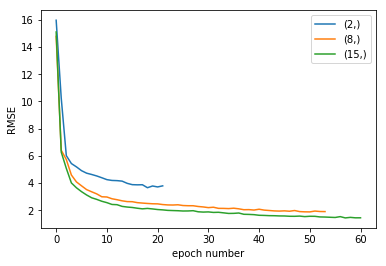

In [14]:
for param_hidden in param_hidden_layers:
    regMLP = regMLPs[param_hidden]
    plt.plot(np.sqrt(regMLP.loss_curve_), label = str(param_hidden))

plt.legend()
plt.ylabel('RMSE')
plt.xlabel('epoch number')

## 4)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

param_hidden_layers = (15,)

n_folds = 5
k_folds = KFold(n_splits=n_folds)
lrate = [0.005, 0.01, 1]

for lrate_ in lrate:
    aRMSE = 0
    for train_idx, test_idx in k_folds.split(X_train):
        regMLP = MLPRegressor(activation = 'tanh',
                              solver = 'sgd',
                              learning_rate='constant',
                              random_state=42,
                              batch_size=40,
                              learning_rate_init = lrate_,
                              hidden_layer_sizes = param_hidden)
        stdScaler = StandardScaler()
        xTrain = stdScaler.fit_transform(X_train.iloc[train_idx,:])
        yTrain = y_train.iloc[train_idx]
            
        regMLP.fit(xTrain,yTrain)
        aRMSE += np.sqrt(mean_squared_error(y_train.iloc[test_idx],
                                            regMLP.predict(stdScaler.transform(X_train.iloc[test_idx,:]))))/n_folds
    
    print '<learning rate: {}>\n Average RMSE (CV): {}\n'.format(lrate_,aRMSE)


<learning rate: 0.005>
 Average RMSE (CV): 3.82804387751

<learning rate: 0.01>
 Average RMSE (CV): 4.36444577137

<learning rate: 1>
 Average RMSE (CV): 3.91685403205e+31

